In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

In [2]:
def find_closest_centroids(X, centroids):
    
    def find_closest_centroid(x, centroids):
        dists = np.apply_along_axis(lambda a: ((x-a)**2).sum(), 1, centroids)
        return np.argmin(dists)
    
    idx = np.apply_along_axis(find_closest_centroid, 1, X, centroids=centroids)
    return idx


def compute_centroids(X, idx, k):
    centroids = np.array(list(map(lambda i: X[idx==i].mean(axis=0), range(k))))
    return centroids


def plot_progress_kmeans(X, centroids, previous_centroids, idx, k, max_iters, i):
    plt.subplot(max_iters//2, 2, i+1)
    plt.scatter(X[:, 0], X[:, 1], c=idx, zorder=0)
    for x, y, prev_x, prev_y in zip(centroids[:, 0],
                                    centroids[:, 1],
                                    previous_centroids[:, 0],
                                    previous_centroids[:, 1]):
        plt.annotate('', xy=(x, y), xytext=(prev_x, prev_y),
                     arrowprops=dict(color='dimgray', width=0.5, headwidth=5, headlength=5),
                     zorder=1)
    plt.scatter(previous_centroids[:, 0], previous_centroids[:, 1], c='b', marker='x',
                s=80, zorder=2, label='Previous centroids')
    plt.scatter(centroids[:, 0], centroids[:, 1], c='r', marker='x',
                s=80, zorder=3, label='New centroids')
    plt.xlabel(iris.feature_names[0])
    plt.ylabel(iris.feature_names[1])
    plt.title('Centroid assignments after iteration {}'.format(i+1))
    plt.legend()
    
    
def run_kmeans(X, initial_centroids, max_iters, plot_progress=False, verbose=True):
    k = initial_centroids.shape[0]
    centroids = initial_centroids
    previous_centroids = centroids
    
    if plot_progress:
        plt.figure(figsize=(12, 24))
    
    for i in range(max_iters):
        
        if verbose:
            print('k-means iteration {}/{} ...'.format(i+1, max_iters), end='\r')
        
        # Assign points to the closest centroid
        idx = find_closest_centroids(X, centroids)
        
        # Reinitialize centroids not assigned any points
        counts = np.bincount(idx)
        while len(counts)<3 or (counts==0).any():
            centroids = np.vstack([centroids[np.where(counts!=0)],
                                   X[np.random.randint(m, size=k-(counts!=0).sum())]])
            idx = find_closest_centroids(X, centroids)
            counts = np.bincount(idx)
        
        if plot_progress:
            plot_progress_kmeans(X, centroids, previous_centroids, idx, k, max_iters, i)
            previous_centroids = centroids
        
        # Compute new centroids
        centroids = compute_centroids(X, idx, k)
    
    if plot_progress:
        plt.tight_layout()
        plt.show()
        
    return centroids, idx


def distortion_cost(X, centroids, idx):
    m = X.shape[0]
    k = centroids.shape[0]
    
    # Construct selection matrix
    selection_matrix = np.zeros((m, k))
    for i in range(m):
        selection_matrix[i, idx[i]] = 1

    J = ((X - selection_matrix@centroids) ** 2).sum(axis=1).mean()
    return J


def multiple_random_initializaions(X, k, n_init=50):    
    m = X.shape[0]
    max_iters = 10
    np.random.seed(52)
    
    J_min = None
    for i in range(n_init):
        print('Running random initialization {}/{} ...'.format(i+1, n_init), end='\r')
        initial_centroids = X[np.random.randint(m, size=k)]
        centroids, idx = run_kmeans(X, initial_centroids, max_iters, verbose=False)
        J = distortion_cost(X, centroids, idx)
        if J_min is None:
            optimal_centroids = centroids
            optimal_idx = idx
            J_min = J
        else:
            if J < J_min:
                optimal_centroids = centroids
                optimal_idx = idx
                J_min = J
    return optimal_centroids, optimal_idx

In [3]:
iris = load_iris()
X = iris.data[:, 0:2]
y = iris.target

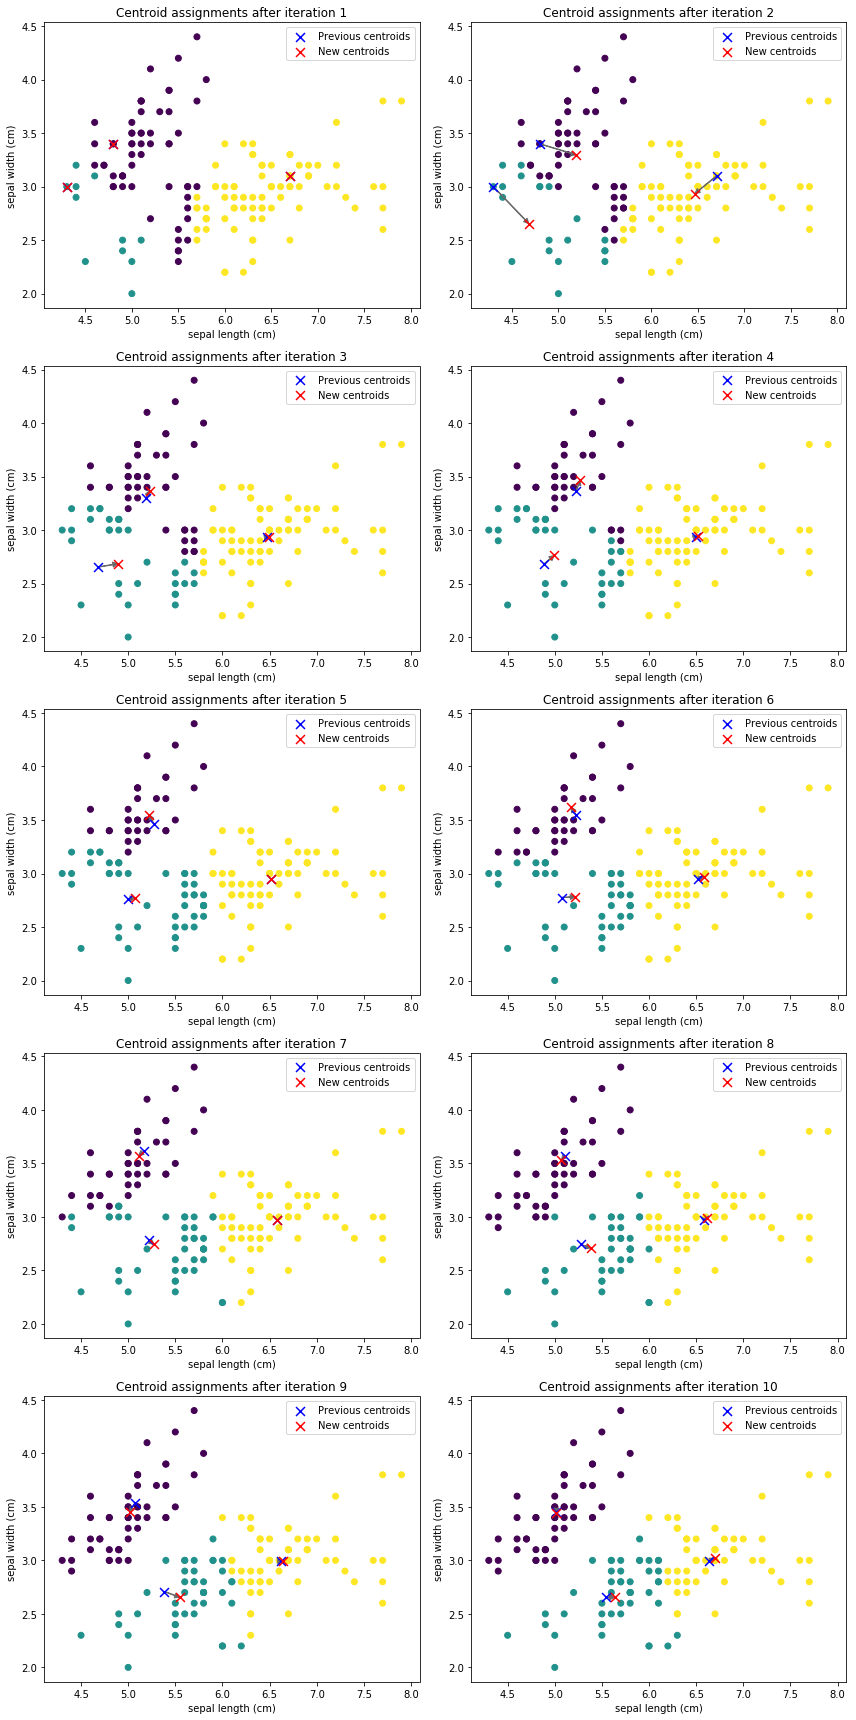

In [4]:
k = 3
m = X.shape[0]
max_iters = 10
np.random.seed(52)

initial_centroids = X[np.random.randint(m, size=k)]
centroids, idx = run_kmeans(X, initial_centroids, max_iters, plot_progress=True)

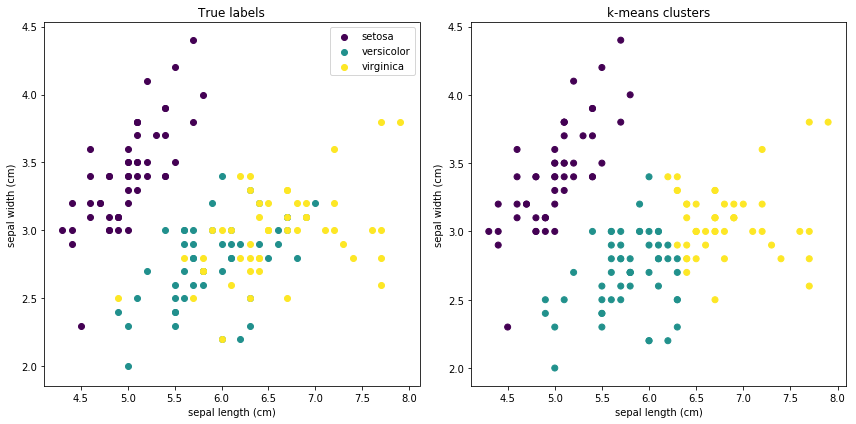

In [5]:
centroids, idx = multiple_random_initializaions(X, k)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
colors = [plt.get_cmap('viridis')(i) for i in [0, 127, 255]]
for lab in range(3):
    ix = np.where(y==lab)
    plt.scatter(X[ix, 0], X[ix, 1], c=colors[lab], label=iris.target_names[lab])
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.title('True labels')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=idx)
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.title('k-means clusters')

plt.tight_layout()
plt.show()